# HW 2 Тестирование алгоритмов кластеризации (k-means, hierarhical и DBSCAN)

In [121]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, DBSCAN

import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)


## Загрузка модели 
Данные по клиентам немецкого банка, которые брали кредиты под различные цели (1000 записей)

https://www.kaggle.com/datasets/uciml/german-credit

In [122]:
data = pd.read_csv('german_credit_data.csv')

In [123]:
data.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


Число строк (клиентов) и столбцов (признаков):

In [124]:
data.shape

(1000, 10)

In [125]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
dtypes: int64(5), object(5)
memory usage: 78.2+ KB


Столбцы:
```
0 Unnamed: 0 - Порядковый номер
1  Age - Возраст - (числовое)
2  Sex - Пол - (текстовое: male, female) (мужчина, женщина)
3  Job - Работа - (числовое: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
4  Housing - Жилье - (текстовое: own, rent, or free) (собственное, арендуемое или не имеет) 
5  Saving accounts - Сберегательный счет - (текстовое - little, moderate, quite rich, rich)  
6  Checking account - Расчетный счет - (текстовое - little, moderate, quite rich, rich) 
7  Credit amount - Сумма кредита - (числовое, в немецких марках)
8  Duration - Срок кредита - (числовое, в месяцах)
9  Purpose - Цель кредита (текстовое - car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)
```

# EDA & Preprocessing

Проверка на пропуски

In [126]:
data.isnull().sum()

Unnamed: 0            0
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64

Заполняем пропуски значением Unknown

In [127]:
data['Saving accounts']=data['Saving accounts'].fillna('Unknown')
data['Checking account']=data['Checking account'].fillna('Unknown')

In [128]:
data.isnull().sum()

Unnamed: 0          0
Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
dtype: int64

In [129]:
#Удаляем ненужный столбец
data.drop(['Unnamed: 0'],axis=1,inplace=True)

In [130]:
data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,Unknown,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,Unknown,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


На какие цели клиенты брали Кредит

In [131]:
values=data['Purpose'].value_counts()
names=names=data['Purpose'].unique()

fig = px.pie(data, values=values, names=names)
fig.show()

In [132]:
data.describe()

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


Кодирование категориальных значений с помощью LabelEncoder

In [133]:
#OneHot Encoding
#data_preproc = pd.get_dummies(data, columns=['Purpose', 'Sex', 'Housing', 'Saving accounts', 'Checking account'])

In [134]:
#OrdinalEncoder
#from sklearn.preprocessing import OrdinalEncoder
#data_preproc = data.copy()
#enc = OrdinalEncoder()
#columns = ['Purpose', 'Sex', 'Housing', 'Saving accounts', 'Checking account']

#data_preproc[columns] = enc.fit_transform(data_preproc[columns])

In [135]:
#LabelEncoder
from sklearn.preprocessing import LabelEncoder
data_preproc = data.copy()
columns = ['Purpose', 'Sex', 'Housing', 'Saving accounts', 'Checking account']

encoders = {}
for c in columns:
    le = LabelEncoder()
    data_preproc[c] = le.fit_transform(data_preproc[c])
    encoders[c] = le

In [136]:
data_preproc.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,1,2,1,0,1,1169,6,5
1,22,0,2,1,1,2,5951,48,5
2,49,1,1,1,1,0,2096,12,3
3,45,1,2,0,1,1,7882,42,4
4,53,1,2,0,1,1,4870,24,1


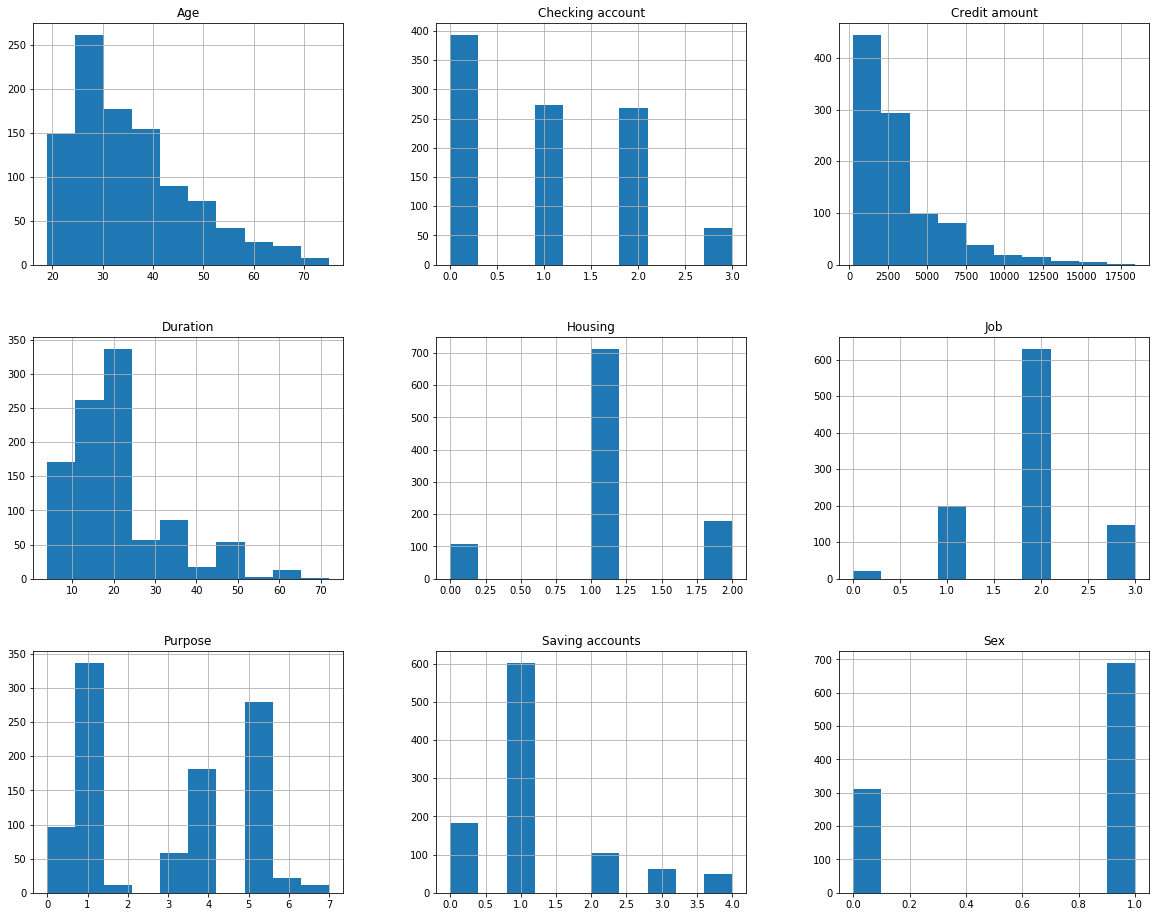

In [137]:
data_preproc.hist(figsize=(20,16));

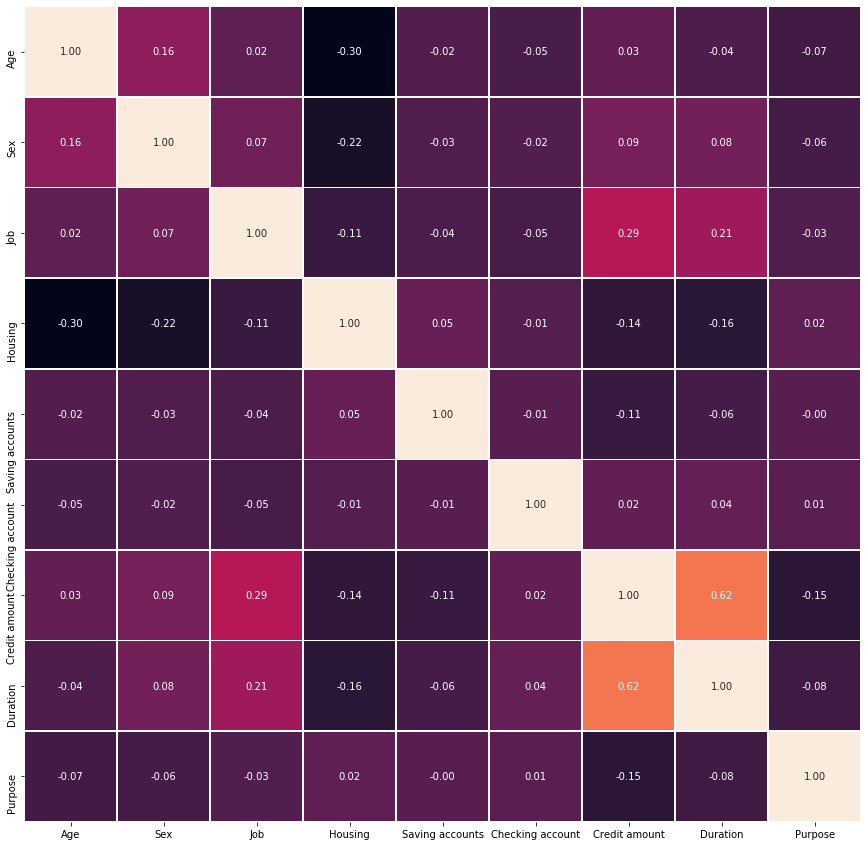

In [138]:
#correlation map
plt.figure(figsize=(15, 15))
sns.heatmap(data_preproc.corr(), annot=True, cbar=False, linewidths=.5, fmt= '.2f')
plt.show()

По матрице корреляции видно, что признаки Crediat amount (сумма кредита) и Duration (срок кредита) очень сильно зависимы. Чем на большую сумму береться кредит, тем на больший срок.

### Нормализация

In [139]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(data_preproc)

data_scaled = pd.DataFrame(X_scaled, columns=data_preproc.columns)
data_scaled.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0.857143,1.0,0.666667,0.5,0.00,0.333333,0.050567,0.029412,0.714286
1,0.053571,0.0,0.666667,0.5,0.25,0.666667,0.313690,0.647059,0.714286
2,0.535714,1.0,0.333333,0.5,0.25,0.000000,0.101574,0.117647,0.428571
3,0.464286,1.0,0.666667,0.0,0.25,0.333333,0.419941,0.558824,0.571429
4,0.607143,1.0,0.666667,0.0,0.25,0.333333,0.254209,0.294118,0.142857


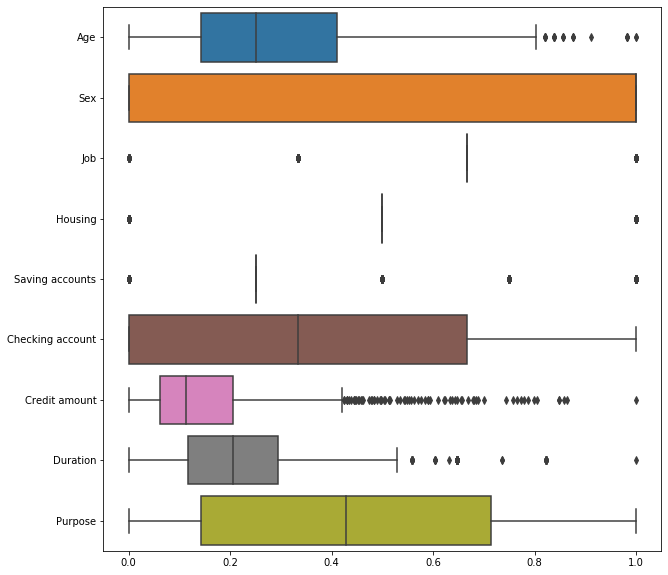

In [140]:
plt.figure(figsize=(10,10))
sns.boxplot(data=data_scaled, orient='h');

### Снижение размерности для визуализации

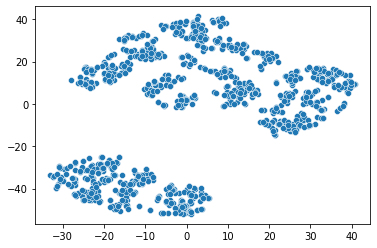

In [141]:
# tSNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=123)
X_tsne = tsne.fit_transform(X_scaled)

sns.scatterplot(X_tsne[:,0], X_tsne[:,1]);

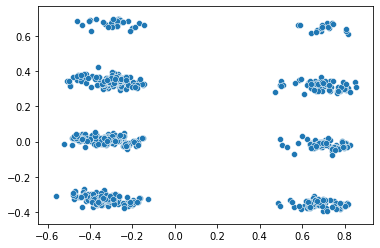

In [142]:
#PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=123)
X_pca = pca.fit_transform(X_scaled)

sns.scatterplot(X_pca[:,0], X_pca[:,1]);

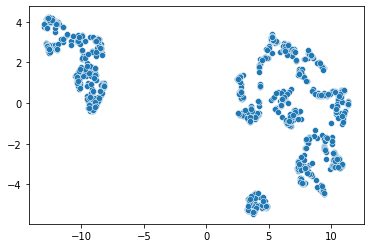

In [143]:
#UMAP
#!pip uninstall umap
#!pip install umap-learn==0.3.10
import umap.umap_ as umap

umap = umap.UMAP(random_state=123)
X_umap = umap.fit_transform(X_scaled)

sns.scatterplot(X_umap[:,0], X_umap[:,1]);

## Кластеризация

### KMeans

In [144]:
#Инерция - метод локтя
inertia = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i, random_state=123).fit(X_scaled)
    labels = kmeans.labels_
    inertia_i = kmeans.inertia_
    inertia.append(inertia_i)

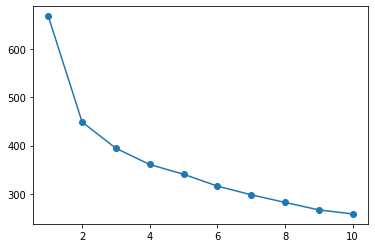

In [145]:
plt.plot(range(1,11), inertia, marker='o');

In [146]:
#Переломный момент
D = []
for i in range(1,9):
    Di = (inertia[i] - inertia[i+1])/(inertia[i-1] - inertia[i])
    D.append(Di)

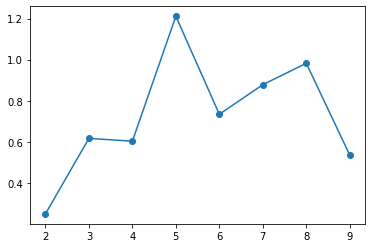

In [147]:
plt.plot(range(2,10), D, marker='o');

In [148]:
# Силуэт
from sklearn.metrics import silhouette_score

silhouette = []
for i in range(2,11):
    kmeans = KMeans(n_clusters=i, random_state=123).fit(X_scaled)
    labels = kmeans.labels_
    score = silhouette_score(X_scaled, labels)
    silhouette.append(score)

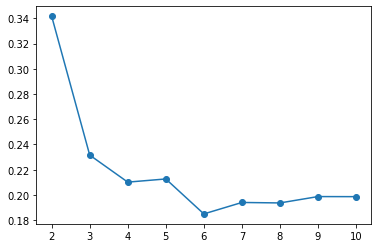

In [149]:
plt.plot(range(2,11), silhouette, marker='o');

По методу локтя видно, что возможно перелом есть при значении 2, графики силуэта и значений переломного момента - потверждают, что по k-means - 2 кластера

### 2 кластера

In [150]:
kmeans = KMeans(n_clusters=2, random_state=123).fit(X_scaled)
labels = kmeans.labels_

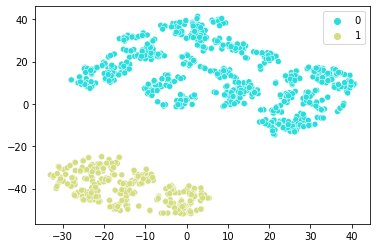

In [151]:
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=labels, palette='rainbow');

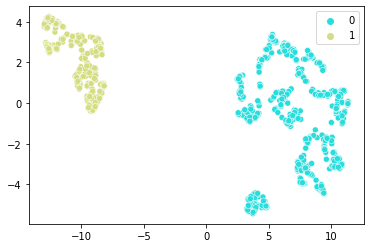

In [152]:
sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=labels, palette='rainbow');

In [153]:
data_preproc['labels'] = labels
data_preproc['labels'].value_counts(normalize=True)

0    0.69
1    0.31
Name: labels, dtype: float64

In [154]:
data_preproc.groupby('labels').median().T.round(2)

labels,0,1
Age,35.0,29.0
Sex,1.0,0.0
Job,2.0,2.0
Housing,1.0,1.0
Saving accounts,1.0,1.0
Checking account,1.0,1.0
Credit amount,2443.5,1959.0
Duration,18.0,18.0
Purpose,3.0,4.0


Група 0: Мужчины, средний возраст 35, которые берут кредит на сумму больше чем в группе 1

Група 1: Женщины, средний возраст 29, которые берут кредит на сумму меньше, чем мужчины    

Проанлизируем различие групп в целях кредита (Purpose)

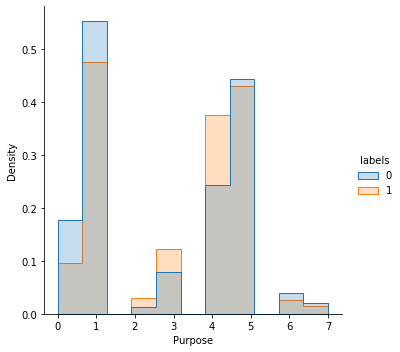

In [155]:
sns.displot(data_preproc, x='Purpose', hue='labels', element="step", stat="density", common_norm=False)


```
0 - car, 
1 - furniture/equipment, 
2 - radio/TV, 
3 - domestic appliances, 
4 - repairs, 
5 - education, 
6 - business, 
7 - vacation/others
```
По Purpose (Целям кридита) видно, что мужчины больше берут кредиты на машины и мебель; а женщины на бытовую технику и ремонт

## hierarhical

Строим дендрограмму

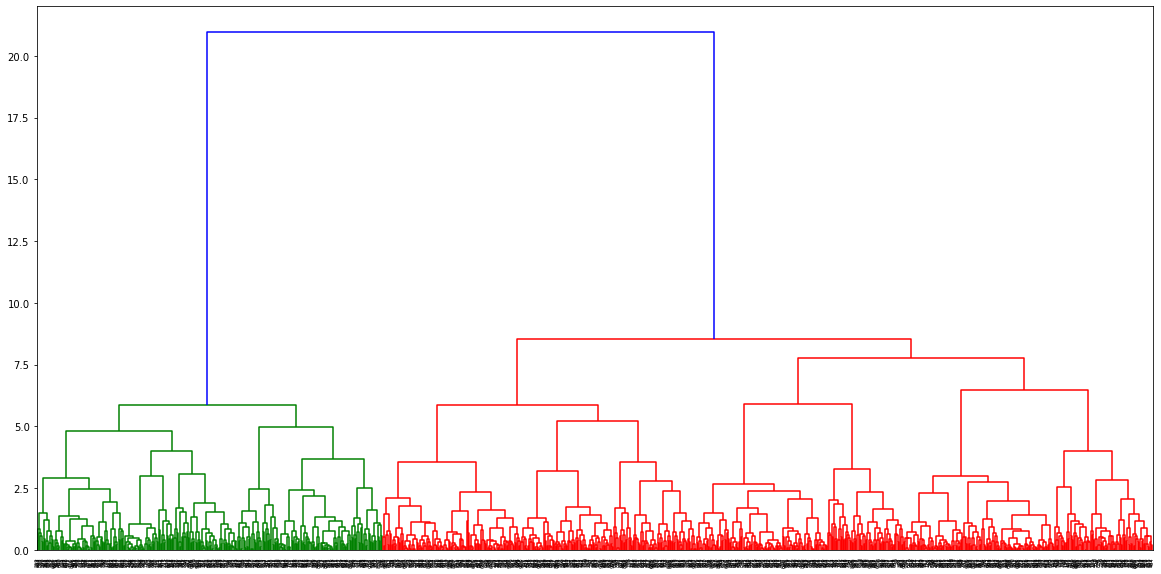

In [156]:
from scipy.cluster.hierarchy import dendrogram, linkage

plt.figure(figsize=(20,10))
linkage_ = linkage(X_scaled, method='ward')
dendrogram_ = dendrogram(linkage_)

Пробуем два Кластера

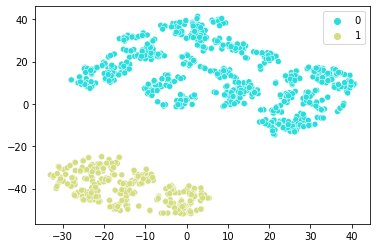

In [157]:
agg = AgglomerativeClustering(n_clusters=2).fit(X_scaled)
labels = agg.labels_
sns.scatterplot(X_tsne[:,0], X_tsne[:,1], hue=labels, palette='rainbow');
#sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=labels, palette='rainbow');

In [158]:
data_preproc['labels'] = labels

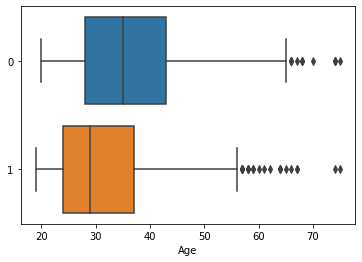

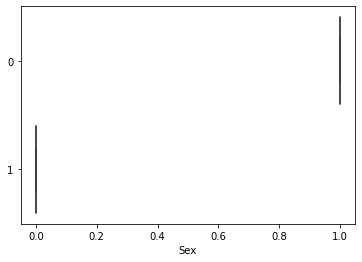

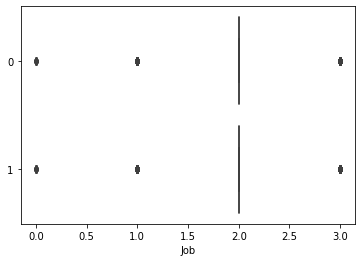

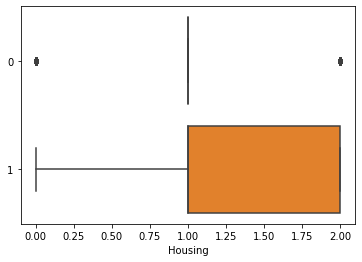

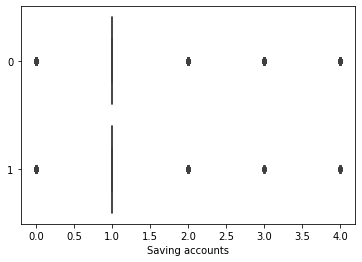

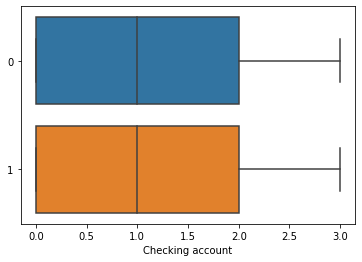

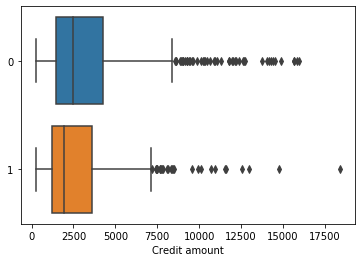

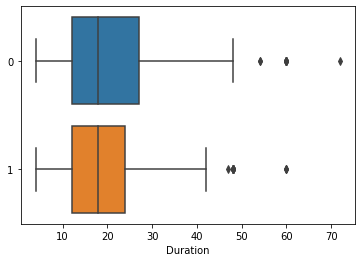

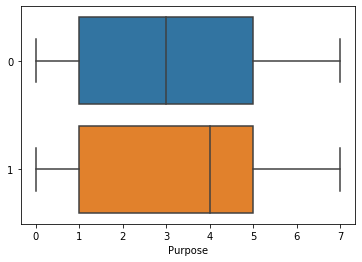

In [159]:
for col in data.columns:
    sns.boxplot(data=data_preproc, x=col, y=labels, orient='h')
    plt.show();

In [160]:
data_preproc.groupby('labels').median().T.round(2)

labels,0,1
Age,35.0,29.0
Sex,1.0,0.0
Job,2.0,2.0
Housing,1.0,1.0
Saving accounts,1.0,1.0
Checking account,1.0,1.0
Credit amount,2443.5,1959.0
Duration,18.0,18.0
Purpose,3.0,4.0


Видно, разбиение получилось аналогично, и в методе k-means

Пробуем разбить на три кластера

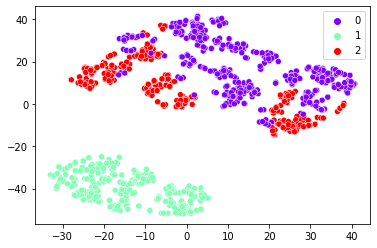

In [161]:
agg = AgglomerativeClustering(n_clusters=3).fit(X_scaled)
labels = agg.labels_
sns.scatterplot(X_tsne[:,0], X_tsne[:,1], hue=labels, palette='rainbow');

In [162]:
data_preproc['labels'] = labels
data_preproc['labels'].value_counts(normalize=True)

0    0.409
1    0.310
2    0.281
Name: labels, dtype: float64

In [163]:
data_preproc.groupby('labels').median().T.round(2)

labels,0,1,2
Age,36,29,32
Sex,1,0,1
Job,2,2,2
Housing,1,1,1
Saving accounts,1,1,1
Checking account,0,1,2
Credit amount,2375,1959,2577
Duration,18,18,18
Purpose,1,4,4


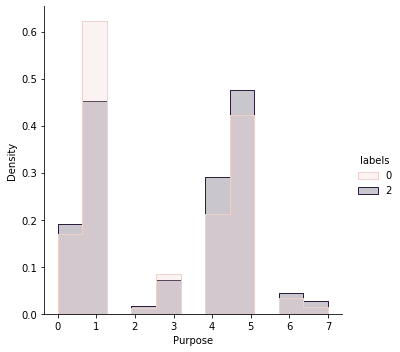

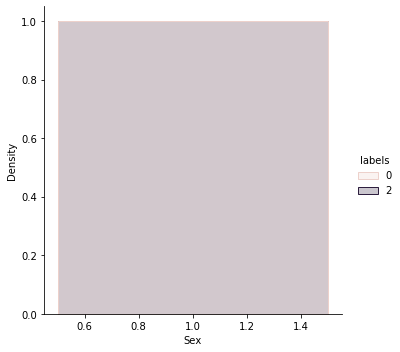

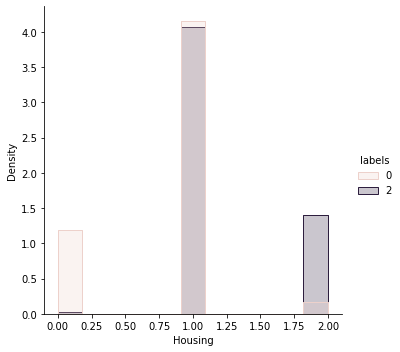

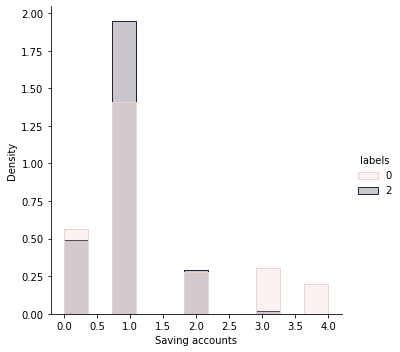

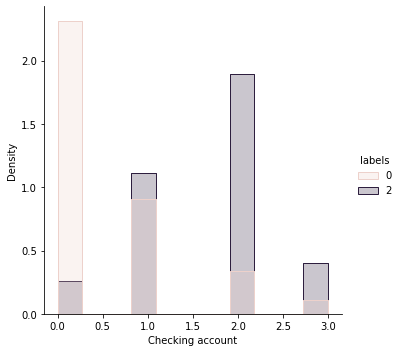

In [164]:
#sns.displot(data_preproc, x='Purpose', hue='labels', element="step", stat="density", common_norm=False)
for c in columns:
  sns.displot(data_preproc[data_preproc['labels'] != 1], x=c, hue='labels', element="step", stat="density", common_norm=False)

По дендрограмме и по полученным данным, видим, что группа Мужчин разбилась на две подгруппы:
- Мужчины постарше (средний возраст 36), более богатые, имеющие собственное жилье, которые берут кредит на меньшую сумму. На мебель/оборудование берут кредит чаще, чем мужчины из второй группы
- Мужчины моложе (средний возраст 32), без собственного жилья, более бедные, которые берут кредит на большую сумму. На ремонт и образование берут кредит чаще, чем мужчины из первой группы

### DBScan

In [165]:
from tqdm import tqdm
def dbscan_clustering(eps_range, X):
    eps_range = eps_range
    silhouette = []
    clusters = []
    for i in tqdm(eps_range):
        dbscan = DBSCAN(eps=i).fit(X)
        labels = dbscan.labels_
        uniq_labels = np.unique(labels)
        n_clusters = len(uniq_labels[uniq_labels != -1])
        if n_clusters > 1:
            score = silhouette_score(X, labels)
        else:
            score = 0
        silhouette.append(score)
        clusters.append(n_clusters)
        
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.plot(eps_range, silhouette, marker='o', color=color)
    ax1.set_xlabel('eps')
    ax1.set_ylabel('silhouette', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.plot(eps_range, clusters, marker='o', color=color)
    ax2.set_ylabel('n_clusters', color=color)  
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:02<00:00, 16.59it/s]


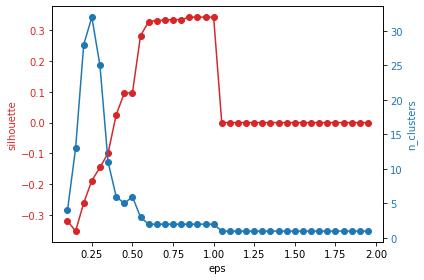

In [166]:
eps_range = np.arange(0.1,2,0.05)
dbscan_clustering(eps_range, X_scaled)

Рассматриваем промежуток 0.4 - 0.65, так ка здесь значение силуэта максимально, а количество кластеров постоянно

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 16.42it/s]


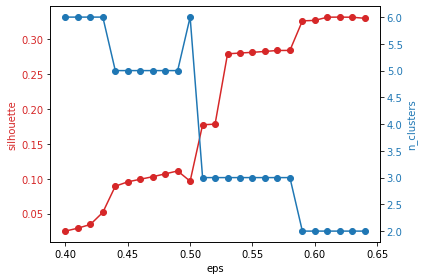

In [167]:
eps_range = np.arange(0.4,0.65,0.01)
dbscan_clustering(eps_range, X_scaled)

Строим график расстояние до ближащих соседей от eps

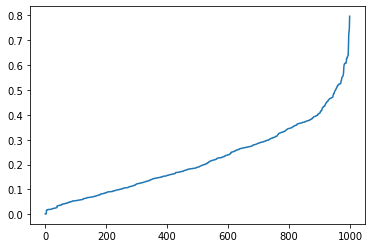

In [168]:
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=5)
nbrs = neighbors.fit(X_scaled)
distance, indices = nbrs.kneighbors(X_scaled)

distance = np.sort(distance, axis=0)
distance = distance[:,1]
plt.plot(distance)

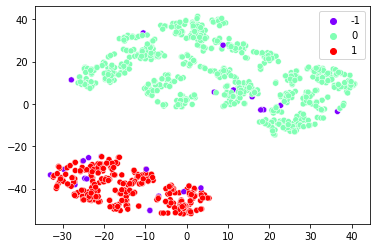

In [169]:
dbscan = DBSCAN(eps=0.6).fit(X_scaled)
labels = dbscan.labels_
sns.scatterplot(X_tsne[:,0], X_tsne[:,1], hue=labels, palette='rainbow');
#sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=labels, palette='rainbow');

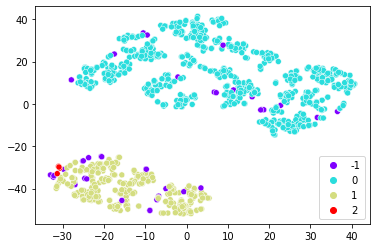

In [170]:
dbscan = DBSCAN(eps=0.55).fit(X_scaled)
labels = dbscan.labels_
sns.scatterplot(X_tsne[:,0], X_tsne[:,1], hue=labels, palette='rainbow');

### Выводы

Сравнивая три метода, наболее интересный результат получился в результате Иерархической кластеризации.

В результате можно выделить три группы:
- Женщины (средний возраст 29), которые берут кредит на сумму меньше, чем мужчины. И чаще берут кредит на бытовую технику и ремонт, чем мужчины
- Мужчины постарше (средний возраст 36), более богатые, имеющие собственное жилье, которые берут кредит на меньшую сумму. На мебель/оборудование берут кредит чаще, чем мужчины из второй группы
- Мужчины моложе (средний возраст 32), без собственного жилья, более бедные, которые берут кредит на большую сумму. На ремонт и образование берут кредит чаще, чем мужчины из первой группы